In [89]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
import os
import numpy as np
import cv2

In [91]:
depth_base_path = "/bd_byta6000i0/users/surgicaldinov2/kyyang/Depth-Anything-V2/out"
seg_base_path = (
    "/bd_byta6000i0/users/surgicaldinov2/kyyang/segmentation_on_cholec80/npys"
)

In [92]:
filepath = "/bd_byta6000i0/users/sam2/wr/SU2024/cholec80/videos_1fps_frame/video15_1fps/210.png"


In [5]:
from PIL import Image

In [6]:
dimension = 224

In [7]:
depth = (
    Image.open(filepath)
    .convert(mode="L")
    .resize((dimension, dimension), Image.Resampling.LANCZOS)
)

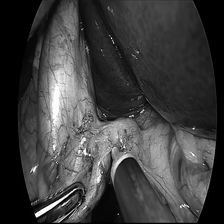

In [8]:
depth

In [88]:
import argparse
import logging
import math
import os
import sys
from functools import partial

sys.path.append(".")

import dinov2.distributed as distributed
import torch
import wandb
from dinov2.data import (
    DataAugmentationDINO,
    DataAugmentationHEMA,
    MaskingGenerator,
    SamplerType,
    collate_data_and_cast,
    collate_data_and_cast_with_depth,
    collate_data_and_cast_with_depth_and_mask,
    make_data_loader,
    make_dataset,
)
from dinov2.fsdp import FSDPCheckpointer
from dinov2.logging import MetricLogger
from dinov2.train.ssl_meta_arch import SSLMetaArch
from dinov2.utils.config import setup
from dinov2.utils.utils import CosineScheduler, smooth_rank_measure
from fvcore.common.checkpoint import PeriodicCheckpointer

In [83]:
data_transform = DataAugmentationDINO(
    (0.32, 1),
    (0.05, 0.32),
    8,
    global_crops_size=224,
    local_crops_size=98,
)

In [123]:
dataset = make_dataset(
    dataset_str="HemaStandardDataset:root=/bd_byta6000i0/users/surgical_depth/DinoBloom:shuffle=1",
    transform=data_transform,
    target_transform=lambda _: (),
)

Loading  /bd_byta6000i0/users/surgical_depth/DinoBloom/cholec.txt


In [125]:
dataset[10][5].shape

torch.Size([1, 224, 224])

In [86]:
img_size = 224
patch_size = 14
inputs_dtype = torch.half
n_tokens = (img_size // patch_size) ** 2

In [87]:
mask_generator = MaskingGenerator(
    input_size=(img_size // patch_size, img_size // patch_size),
    max_num_patches=0.5 * img_size // patch_size * img_size // patch_size,
)

In [118]:
collate_fn = partial(
    collate_data_and_cast_with_depth_and_mask,
    mask_ratio_tuple=(0.1, 0.5),
    mask_probability=0.5,
    n_tokens=n_tokens,
    mask_generator=mask_generator,
    dtype=inputs_dtype,
)

In [126]:
sampler_type = SamplerType.EPOCH
data_loader = make_data_loader(
    dataset=dataset,
    batch_size=16,
    num_workers=1,
    shuffle=True,
    seed=42,  # TODO: Fix this -- cfg.train.seed
    sampler_type=sampler_type,
    sampler_advance=0,  # TODO (qas): fix this -- start_iter * cfg.train.batch_size_per_gpu,
    drop_last=True,
    collate_fn=collate_fn,
)

In [127]:
for batch in data_loader:
    first_batch = batch
    break

In [128]:
for key in first_batch:
    try:
        print(key, first_batch[key].shape)
    except:
        print(first_batch[key])

collated_global_crops torch.Size([32, 3, 224, 224])
collated_local_crops torch.Size([128, 3, 98, 98])
collated_masks torch.Size([32, 256])
mask_indices_list torch.Size([1234])
masks_weight torch.Size([1234])
1274
n_masked_patches torch.Size([1])
collated_depth torch.Size([16, 1, 224, 224])
collated_raw_image torch.Size([16, 3, 224, 224])
collated_segmentation torch.Size([16, 1, 224, 224])


In [41]:
first_batch["collated_depth"]

tensor([[[[0.4392, 0.4392, 0.4392,  ..., 0.7021, 0.7061, 0.6982],
          [0.4392, 0.4392, 0.4353,  ..., 0.7021, 0.7061, 0.7100],
          [0.4392, 0.4353, 0.4353,  ..., 0.7021, 0.7021, 0.7061],
          ...,
          [0.5566, 0.5527, 0.5527,  ..., 0.7607, 0.7607, 0.7646],
          [0.5566, 0.5566, 0.5566,  ..., 0.7607, 0.7646, 0.7646],
          [0.5605, 0.5605, 0.5566,  ..., 0.7646, 0.7646, 0.7646]]],


        [[[0.5449, 0.5410, 0.5371,  ..., 0.3059, 0.3176, 0.3254],
          [0.5449, 0.5410, 0.5371,  ..., 0.3098, 0.3215, 0.3333],
          [0.5410, 0.5371, 0.5332,  ..., 0.3176, 0.3293, 0.3411],
          ...,
          [0.9331, 0.9253, 0.9175,  ..., 0.6904, 0.6943, 0.6943],
          [0.9292, 0.9175, 0.9058,  ..., 0.6943, 0.6943, 0.6943],
          [0.9175, 0.9058, 0.8901,  ..., 0.6982, 0.6982, 0.7021]]],


        [[[0.3882, 0.3843, 0.3804,  ..., 0.1294, 0.1372, 0.1372],
          [0.3843, 0.3843, 0.3804,  ..., 0.1294, 0.1372, 0.1412],
          [0.3843, 0.3804, 0.3765,  ..

In [ ]:
import torch
import torch.nn.functional as F


def depth_loss(raw_image_patch_tokens, depths, depth_temperature):
    """
    Computes the depth supervision loss based on pairwise similarities *within* each sample.

    Args:
        raw_image_patch_tokens (torch.Tensor): Shape [B, N, D].
                                              Patch tokens (features) from the student model.
                                              N = number of patches, e.g., (H/14)*(W/14).
                                              D = feature dimension.
        depths (torch.Tensor): Shape [B, 1, H, W]. Original high-resolution depth maps.
        depth_temperature (float): Sigma (σ) value for the Gaussian kernel controlling
                                   depth similarity bandwidth.

    Returns:
        torch.Tensor: Scalar depth supervision loss (L_depth), averaged over the batch.
    """
    B, _, H, W = depths.shape
    _B_tokens, N, D = raw_image_patch_tokens.shape  # N = (H/patch_size)*(W/patch_size)

    # --- Infer Patch Size (same as before) ---
    patch_size_h = H / (N**0.5)
    patch_size_w = W / (N**0.5)
    if H % 14 == 0 and W % 14 == 0 and N == (H // 14) * (W // 14):
        patch_size = 14
    elif H % 16 == 0 and W % 16 == 0 and N == (H // 16) * (W // 16):
        patch_size = 16
    else:
        patch_size = int((H * W / N) ** 0.5)
        print(
            f"Warning: Could not perfectly infer patch size. Using approx: {patch_size}"
        )
        if H % patch_size != 0 or W % patch_size != 0:
            raise ValueError(
                f"Inferred patch size {patch_size} does not divide H={H} or W={W}"
            )

    # --- 1. Downsample Depths (same as before) ---
    downsampled_depths = F.avg_pool2d(depths, kernel_size=patch_size, stride=patch_size)
    # Shape: [B, 1, N_h, N_w]

    # Flatten the spatial dimensions for each sample independently
    # Shape becomes [B, N]
    downsampled_depths_flat_per_batch = downsampled_depths.view(B, -1)

    # --- 2. Calculate Pairwise Depth Similarity (T_ij) - BATCH-WISE ---
    # We want a result of shape [B, N, N] where T_ij_batch[b, i, j] = similarity between patch i and j of sample b.
    # Use broadcasting within the batch dimension:
    # depths [B, N] -> unsqueeze(2) -> [B, N, 1]
    # depths [B, N] -> unsqueeze(1) -> [B, 1, N]
    # Broadcasting subtraction [B, N, 1] - [B, 1, N] gives pairwise diffs [B, N, N]
    delta_ij_batch = torch.abs(
        downsampled_depths_flat_per_batch.unsqueeze(2)
        - downsampled_depths_flat_per_batch.unsqueeze(1)
    )  # Shape [B, N, N]

    # Apply Gaussian kernel element-wise
    # Add a small epsilon for numerical stability if depth_temperature is zero
    T_ij_batch = torch.exp(
        -delta_ij_batch / (depth_temperature + 1e-6)
    )  # Shape [B, N, N]

    # --- 3. Calculate Feature Similarity (S_ij_scaled) - BATCH-WISE ---
    # We want a result of shape [B, N, N] where S_ij_batch[b, i, j] = similarity between token i and j of sample b.
    # Tokens are already [B, N, D]

    # L2-normalize the features along the feature dimension (D)
    norm_tokens = F.normalize(raw_image_patch_tokens, p=2, dim=2)  # Shape [B, N, D]

    # Compute pairwise cosine similarities using Batch Matrix Multiplication (bmm)
    # We need [B, N, D] @ [B, D, N] -> [B, N, N]
    S_ij_batch = torch.bmm(norm_tokens, norm_tokens.transpose(1, 2))  # Shape [B, N, N]

    # Scale similarities to [0, 1]
    S_ij_scaled_batch = (S_ij_batch + 1.0) / 2.0  # Shape [B, N, N]

    # --- 4. Compute Depth Supervision Loss (L_depth) ---
    # Use Mean Squared Error (MSE). F.mse_loss computes the mean over all elements by default.
    # This will average the loss over all B*N*N pairs correctly.
    # We compare the similarity matrices for each sample element-wise.
    loss = F.mse_loss(S_ij_scaled_batch, T_ij_batch)

    return loss

In [ ]:
B, H, W, D = 4, 224, 224, 1024
patch_size = 14
N = (H // patch_size) * (W // patch_size)  # N = 256
dummy_tokens = torch.randn(B, N, D)
dummy_depths = torch.rand(B, 1, H, W)
temperature = 0.1

loss_value = depth_loss(dummy_tokens, dummy_depths, temperature)
print(f"Calculated Within-Batch Depth Loss: {loss_value.item()}")

Calculated Within-Batch Depth Loss: 0.11172181367874146
